## Import libraries and define file paths

In [1]:
#Import libraries
import random
import csv
import os
import io
import cv2
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#General file paths
projectDir = os.getcwd() + "/"
parentDir = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/"
dataPath = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/isic-2024-challenge/"

#Metadata file paths
metaPath = dataPath + "train-metadata.csv"

#Image input file path
hdf5_file_in = dataPath + "train-image.hdf5"

#Image output file path
hdf5_file_out = dataPath + "sample-image.hdf5"

#CSV output file path
csv_file_out = dataPath + "sample-metadata.csv"

## Generate sample list

In [3]:
#Import isic ids from metadata (corresponds to the objects in the HDF5 file)
metadata = pd.read_csv(metaPath, sep=",")
#isic_ids = metadata["isic_id"]

/tmp/ipykernel_59098/2436079216.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metaPath, sep=",")


In [4]:
#Split into malignant and benign
meta_malign = metadata[metadata["target"]==1]
meta_benign = metadata[metadata["target"]==0]

isic_ids_malign = meta_malign["isic_id"].reset_index(drop=True)
isic_ids_benign = meta_benign["isic_id"].reset_index(drop=True)

print("Number of malignant ids:", len(isic_ids_malign))
print("Number of benign ids:", len(isic_ids_benign))

Number of malignant ids: 393
Number of benign ids: 400666


In [5]:
n=66
random.seed(125)
subset_indices = range(len(isic_ids_malign)-1) #Ordered list of the indices in isic_ids
subset_indices = random.sample(subset_indices, n) #Sample of size n taken from the indices
subset = isic_ids_malign[subset_indices] #isic_ids associated to these indices

In [6]:
#Generate subset of isic ids to export to hdf5 file
random.seed(125)

#n = number of samples to take
def generate_isic_list(isic_ids, n=66):
    subset_indices = range(len(isic_ids)-1) #Ordered list of the indices in isic_ids
    subset_indices = random.sample(subset_indices, n) #Sample of size n taken from the indices
    return  isic_ids[subset_indices].tolist() #isic_ids associated to these indices


isic_ids_mal_subset = generate_isic_list(isic_ids_malign)
isic_ids_ben_subset = generate_isic_list(isic_ids_benign)
isic_ids_subset = isic_ids_mal_subset + isic_ids_ben_subset

## Import from initial file

In [7]:
#Retrieve raw data from inital HDF5 file and save in a list containing
#the tuples (isic_id, data)
bytes_imgs = []
with h5py.File(hdf5_file_in, 'r') as h5file:
    for isic_id in isic_ids_subset:
        bytes_imgs.append((isic_id, h5file[isic_id][()]))

## Export to new file

In [8]:
#Export the file for each image one by one
with h5py.File(hdf5_file_out, 'w') as h5file:
    for item in bytes_imgs:
        id = item[0]
        img = item[1]
        h5file.create_dataset(id, data=img)

In [10]:
#Export the target data in csv form
meta = metadata[metadata["isic_id"].isin(isic_ids_subset)]

In [11]:
meta.to_csv(csv_file_out, index=False)

## Confirm that data was properly copied

In [12]:
#Function to show image
def show_img(image):
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()

In [14]:
#Image chosen for comparison
isic_id = isic_ids_subset[0]

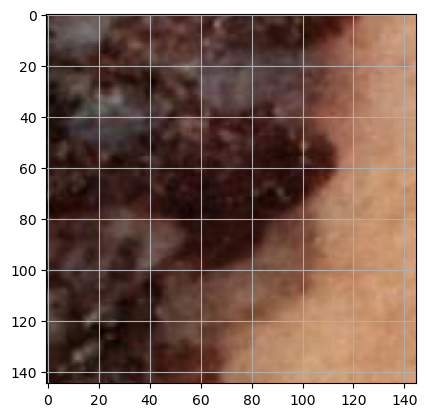

Native form: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x91\x00\x91\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9

In [15]:
#Display of image using input data file
f = h5py.File(hdf5_file_in, 'r')
image = np.array(
        Image.open(io.BytesIO(f[isic_id][()]))
        )
show_img(image)
print("Native form:", f[isic_id][()])

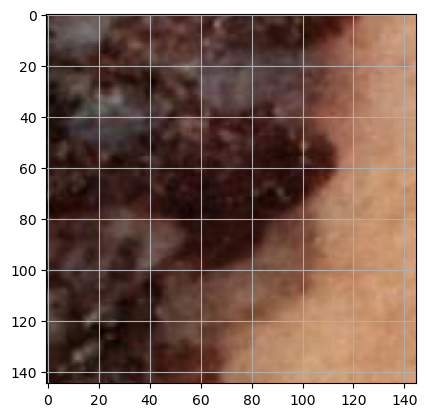

Native form: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x91\x00\x91\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9

In [16]:
#Display of image using output data file
f = h5py.File(hdf5_file_out, 'r')
image = np.array(
        Image.open(io.BytesIO(f[isic_id][()]))
        )
show_img(image)
print("Native form:", f[isic_id][()])